## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor

In [1]:
import pandas as pd
import time
from datetime import date
from datetime import datetime
import re
import warnings

warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/countries-of-the-world/countries of the world.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [2]:
# фиксируем RANDOM_SEED, чтобы наши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [5]:
cs_world = pd.read_csv('../input/countries-of-the-world/countries of the world.csv')


In [6]:
cs_world.head()

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0","259,5",10,15,75,2,"22,46","3,27",NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",NaN,NaN,NaN


In [7]:
for dataset in [df_train, df_test, sample_submission]:
    dataset.columns = list(map(lambda x: (x.replace(' ', '_')).lower(), dataset.columns))

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
restaurant_id        40000 non-null object
city                 40000 non-null object
cuisine_style        30717 non-null object
ranking              40000 non-null float64
rating               40000 non-null float64
price_range          26114 non-null object
number_of_reviews    37457 non-null float64
reviews              40000 non-null object
url_ta               40000 non-null object
id_ta                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [9]:
df_train.head(5)

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,url_ta,id_ta
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
restaurant_id        10000 non-null object
city                 10000 non-null object
cuisine_style        7693 non-null object
ranking              10000 non-null float64
price_range          6525 non-null object
number_of_reviews    9343 non-null float64
reviews              9998 non-null object
url_ta               10000 non-null object
id_ta                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [11]:
df_test.head(5)

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [12]:
sample_submission.head(5)

,restaurant_id,rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [13]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
restaurant_id    10000 non-null object
rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [14]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
restaurant_id        50000 non-null object
city                 50000 non-null object
cuisine_style        38410 non-null object
ranking              50000 non-null float64
price_range          32639 non-null object
number_of_reviews    46800 non-null float64
reviews              49998 non-null object
url_ta               50000 non-null object
id_ta                50000 non-null object
sample               50000 non-null int64
rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* city: Город 
* cuisine_style: Кухня
* ranking: Ранг ресторана относительно других ресторанов в этом городе
* price_range: Цены в ресторане в 3 категориях
* number_of_reviews: Количество отзывов
* reviews: 2 последних отзыва и даты этих отзывов
* url_ta: страница ресторана на 'www.tripadvisor.com' 
* id_ta: ID ресторана в TripAdvisor
* rating: Рейтинг ресторана

In [16]:
data.sample(5)

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating
34081,id_4130,Barcelona,NaN,4131.0,NaN,NaN,"[[], []]",/Restaurant_Review-g187497-d986416-Reviews-Res...,d986416,1,5.0
8312,id_8312,Prague,"['Bar', 'Czech', 'Central European', 'European...",1580.0,$,52.0,"[['Nice dinner away from the crowd!', 'Good fo...",/Restaurant_Review-g274707-d694900-Reviews-U_S...,d694900,0,0.0
36479,id_8624,Paris,"['French', 'European']",8626.0,$,166.0,"[['Normal', 'Small bistro, reasonable pricing ...",/Restaurant_Review-g187147-d783245-Reviews-Bis...,d783245,1,3.5
4912,id_4912,Paris,"['Asian', 'Taiwanese', 'Vietnamese']",6115.0,$,16.0,"[['great home made food', 'The place to be if ...",/Restaurant_Review-g187147-d1328307-Reviews-Op...,d1328307,0,0.0
48292,id_4176,Barcelona,"['Cafe', 'Fast Food', 'Spanish', 'Pub', 'Gastr...",4177.0,NaN,NaN,"[[], []]",/Restaurant_Review-g187497-d12839942-Reviews-S...,d12839942,1,5.0


In [17]:
data.reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

## 1. Обработка NAN и работа с пропусками.
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
restaurant_id        50000 non-null object
city                 50000 non-null object
cuisine_style        38410 non-null object
ranking              50000 non-null float64
price_range          32639 non-null object
number_of_reviews    46800 non-null float64
reviews              49998 non-null object
url_ta               50000 non-null object
id_ta                50000 non-null object
sample               50000 non-null int64
rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [19]:
# создадим новые столбцы, где отразим наличие пропусков 
for i in ['cuisine_style', 'price_range', 'number_of_reviews']:
    data[i + '_isNAN'] = pd.isna(data[i]).astype('uint8')


In [20]:
data['number_of_reviews_isNAN'].value_counts()

0    46800
1     3200
Name: number_of_reviews_isNAN, dtype: int64

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
restaurant_id              50000 non-null object
city                       50000 non-null object
cuisine_style              38410 non-null object
ranking                    50000 non-null float64
price_range                32639 non-null object
number_of_reviews          46800 non-null float64
reviews                    49998 non-null object
url_ta                     50000 non-null object
id_ta                      50000 non-null object
sample                     50000 non-null int64
rating                     50000 non-null float64
cuisine_style_isNAN        50000 non-null uint8
price_range_isNAN          50000 non-null uint8
number_of_reviews_isNAN    50000 non-null uint8
dtypes: float64(3), int64(1), object(7), uint8(3)
memory usage: 4.3+ MB


In [22]:
data['price_range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: price_range, dtype: int64

In [23]:
#заполним пропуски в price_range самым частым значением
data['price_range'] = data['price_range'].fillna(data['price_range'].value_counts().index[0])

In [24]:
'''преобразовывем столбец с уровнем цен'''
for i in range(len(data)):
    if data['price_range'][i] == '$':
        data['price_range'][i] = 1
    elif data['price_range'][i] == '$$ - $$$':
        data['price_range'][i] = 2
    elif data['price_range'][i] == '$$$$':
        data['price_range'][i] = 3

In [25]:
data['price_range'].value_counts()

2    40402
1     7816
3     1782
Name: price_range, dtype: int64

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
restaurant_id              50000 non-null object
city                       50000 non-null object
cuisine_style              38410 non-null object
ranking                    50000 non-null float64
price_range                50000 non-null object
number_of_reviews          46800 non-null float64
reviews                    49998 non-null object
url_ta                     50000 non-null object
id_ta                      50000 non-null object
sample                     50000 non-null int64
rating                     50000 non-null float64
cuisine_style_isNAN        50000 non-null uint8
price_range_isNAN          50000 non-null uint8
number_of_reviews_isNAN    50000 non-null uint8
dtypes: float64(3), int64(1), object(7), uint8(3)
memory usage: 4.3+ MB


In [27]:
# заполним пропуски медианным значением
data['number_of_reviews'] = data['number_of_reviews'].fillna(data['number_of_reviews'].median())

In [28]:
# заполним пропуски временным значением
data['cuisine_style'] = data['cuisine_style'].fillna('Russ')

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
restaurant_id              50000 non-null object
city                       50000 non-null object
cuisine_style              50000 non-null object
ranking                    50000 non-null float64
price_range                50000 non-null object
number_of_reviews          50000 non-null float64
reviews                    49998 non-null object
url_ta                     50000 non-null object
id_ta                      50000 non-null object
sample                     50000 non-null int64
rating                     50000 non-null float64
cuisine_style_isNAN        50000 non-null uint8
price_range_isNAN          50000 non-null uint8
number_of_reviews_isNAN    50000 non-null uint8
dtypes: float64(3), int64(1), object(7), uint8(3)
memory usage: 4.3+ MB


In [30]:
data['reviews'][1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

In [31]:
# заменим пропуски случайным значением, добавим дату для дальнейшего отслеживания пропуска
data['reviews'] = data['reviews'].fillna('qwe')

In [32]:
# пропуски заполнены
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
restaurant_id              50000 non-null object
city                       50000 non-null object
cuisine_style              50000 non-null object
ranking                    50000 non-null float64
price_range                50000 non-null object
number_of_reviews          50000 non-null float64
reviews                    50000 non-null object
url_ta                     50000 non-null object
id_ta                      50000 non-null object
sample                     50000 non-null int64
rating                     50000 non-null float64
cuisine_style_isNAN        50000 non-null uint8
price_range_isNAN          50000 non-null uint8
number_of_reviews_isNAN    50000 non-null uint8
dtypes: float64(3), int64(1), object(7), uint8(3)
memory usage: 4.3+ MB


# 2. Визуализация

### Посмотрим распределение признака

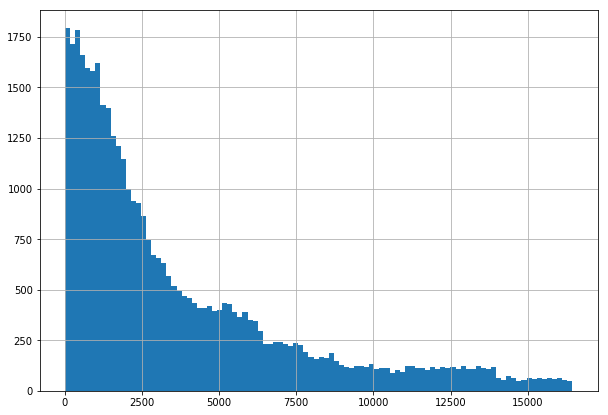

In [33]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

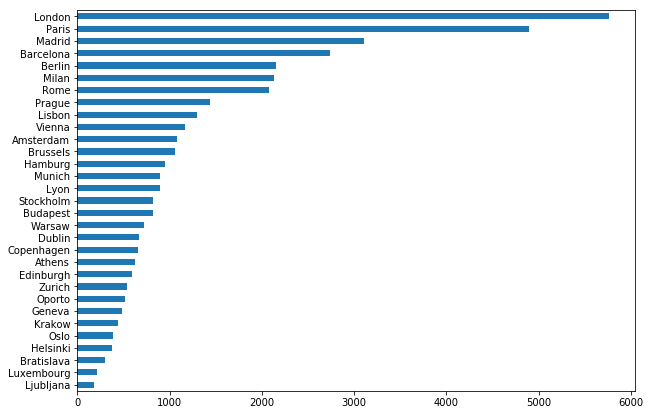

In [34]:
df_train['city'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

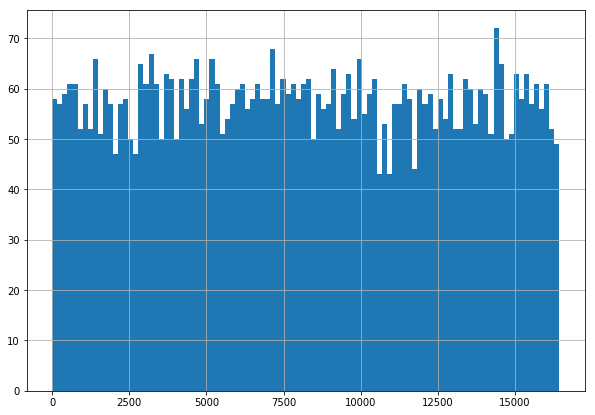

In [35]:
df_train['ranking'][df_train['city'] =='London'].hist(bins=100)

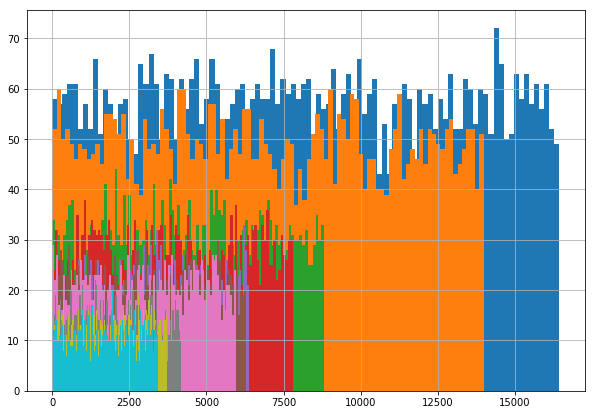

In [36]:
# посмотрим на топ 10 городов
for x in (df_train['city'].value_counts())[0:10].index:
    df_train['ranking'][df_train['city'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за этого мы имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Посмотрим распределение целевой переменной

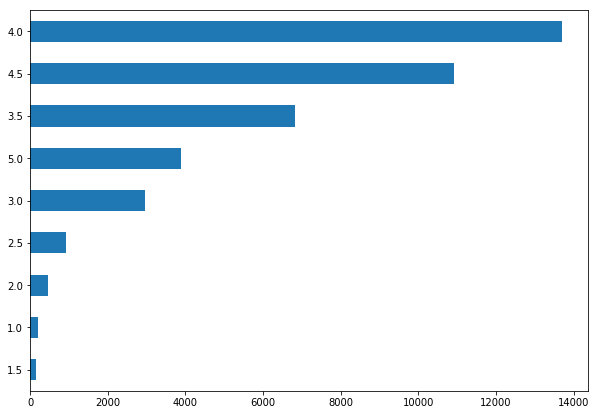

In [37]:
df_train['rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

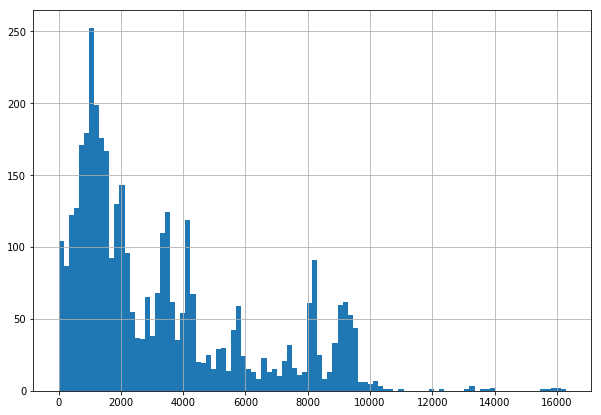

In [38]:
df_train['ranking'][df_train['rating'] == 5].hist(bins=100)

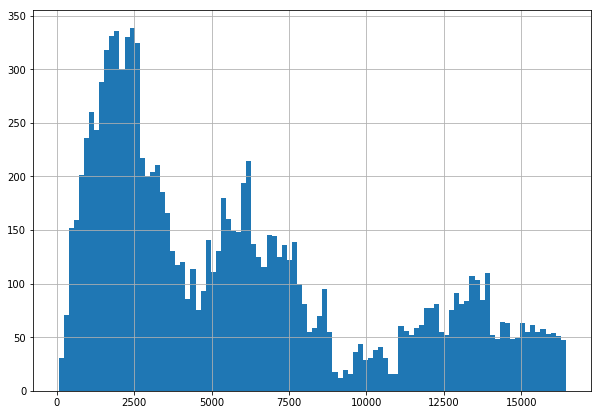

In [39]:
df_train['ranking'][df_train['rating'] < 4].hist(bins=100)

### Корреляция признаков
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

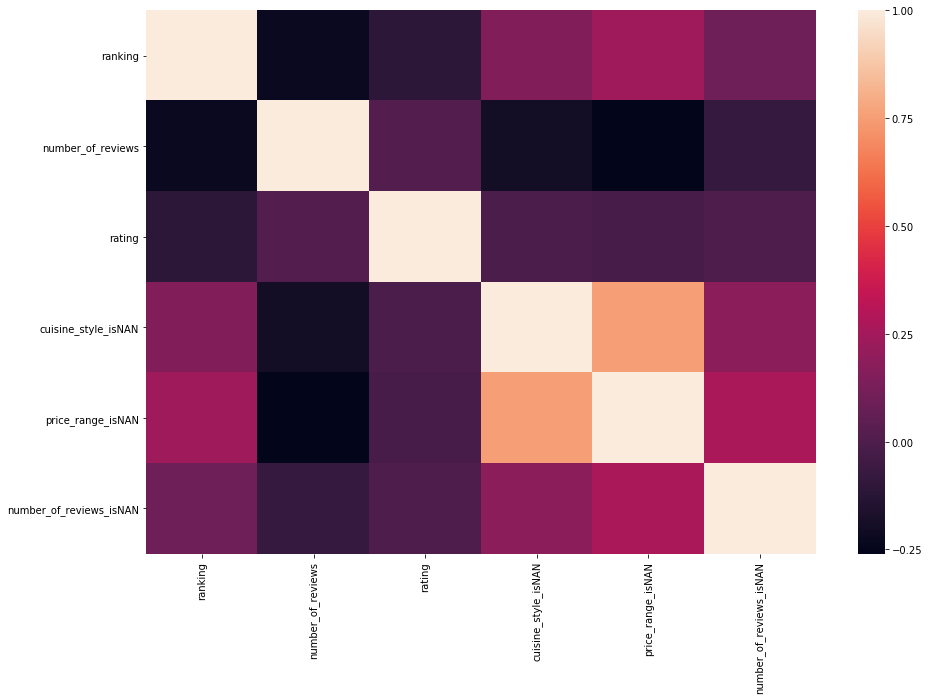

In [40]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Одна из сильнейших положительных корреляций наблюдается между наличием пропусков в признаках 'cuisine_style' и 'prace_range'

# 3. Создаем новые признаки

## 3.1 Создаем признак, показывающий количество кухни в ресторане

In [41]:
data.cuisine_style[0]

"['Bar', 'Pub']"

In [42]:
type(data.cuisine_style[0])

str

In [43]:
regex = re.compile('[a-zA-Z]+')  #  составим регулярку для поиска

'''преобразуем строку кухни в список'''
for i in range(len(data)):
    data['cuisine_style'][i] = re.findall(regex, data['cuisine_style'][i])

In [44]:
type(data.cuisine_style[0])

list

In [45]:
# создадим копию датасета, он нам поможет с заменой пропусков в "cuisine_style"
data2 =data.explode('cuisine_style').copy()
data2['city'][0]

0    Paris
0    Paris
Name: city, dtype: object

In [46]:
# заменяем наше временное значение "Russ" в столбце "cuisine_style" на самое распространенное по стране
# если самое распространенное это "Russ", то ставим "European"
for i in range(len(data)):
    if data['cuisine_style'][i][0] == 'Russ':
        data['cuisine_style'][i] = data2[data2['city'] == data['city'][i]]['cuisine_style'].value_counts().index[0]
    
    if data['cuisine_style'][i] == 'Russ':
        data['cuisine_style'][i] = 'European'

In [47]:
# проверим, осталось ли где-то временное значение "Russian"
len(data[data['cuisine_style'] == 'Russ'])

0

In [48]:
# создадим список всей кухни
all_cuisine = pd.Series(data2['cuisine_style'].unique())


In [49]:
# создаем новый признак, показывающий разнообразие кухни в ресторане

data['cuisine_size'] = None
for i in range(len(data)):
    data['cuisine_size'][i] = len(data['cuisine_style'][i])
data.head()

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,cuisine_style_isNAN,price_range_isNAN,number_of_reviews_isNAN,cuisine_size
0,id_0,Paris,"[Bar, Pub]",12963.0,2,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0,0,0,2
1,id_1,Helsinki,"[European, Scandinavian, Gluten, Free, Options...",106.0,2,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,0,0,0,9
2,id_2,Edinburgh,"[Vegetarian, Friendly]",810.0,2,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0,0,0,2
3,id_3,London,"[Italian, Mediterranean, European, Vegetarian,...",1669.0,3,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,0,0,0,8
4,id_4,Bratislava,"[Italian, Mediterranean, European, Seafood, Ve...",37.0,3,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,0,0,0,9


## 3.2 Создаем столбец, показывающий страну в которой находится ресторан.

In [50]:
# составим словарь, где разобьем города по странам
cities = {'United Kingdom' : ['London', 'Edinburgh'],
    'France': ['Paris', 'Lyon'],
    'Spain': ['Madrid', 'Barcelona'],
    'Germany': ['Berlin', 'Hamburg', 'Munich'],
    'Italy': ['Milan', 'Rome'],
    'Czech Republic': ['Prague'],
    'Portugal': ['Prague', 'Oporto', 'Lisbon'],
    'Austria': ['Vienna'],
    'Netherlands': ['Amsterdam'],
    'Belgium': ['Brussels'],
    'Sweden': ['Stockholm'],
    'Hungary': ['Budapest'],
    'Poland': ['Warsaw', 'Krakow'],
    'Ireland': ['Dublin'],
    'Denmark': ['Copenhagen'],
    'Greece': ['Athens'],
    'Switzerland': ['Zurich', 'Geneva'],
    'Norway': ['Oslo'],
    'Finland': ['Helsinki'],
    'Slovakia': ['Bratislava'],
    'Luxembourg': ['Luxembourg'],
    'Slovenia': ['Ljubljana']
       }

In [51]:

# теперь создадим столбец со страной города
data['country'] = None
for i in range(len(data)):
    for z in cities:
        if data['city'][i] in cities[z]:
            data['country'][i] = z

## 3.3 Создаем столбец, показывающий уровень счастья населения по странам

In [52]:
'''Рейтинг стран мира по уровню счастья населения'''
whr_list = { 'Norway': 7.537,
    'Denmark': 7.522,
    'Switzerland': 7.494,
    'Finland': 7.469,
    'Netherlands': 7.377,
    'Sweden': 7.284,
    'Ireland': 6.977,
    'Germany': 6.951,
    'Belgium': 6.891,
    'Luxembourg': 6.863,
    'United Kingdom': 6.714,
    'Czech Republic': 6.609,
    'France': 6.442,
    'Spain': 6.403,
    'Slovakia': 6.098,
    'Italy': 5.964,
    'Slovenia': 5.758,
    'Greece': 5.227,
    'Hungary': 5.324,
    'Portugal': 5.195,
    'Austria': 7.006,
    'Poland': 5.973,
      }       


In [53]:
# создаем столбец показывающий уровень счастья по стране
data['whr'] = None
for i in range(len(data)):
    for z in whr_list:     
        if data['country'][i] == z:
            data['whr'][i] = whr_list[z]
data['whr']

0        6.442
1        7.469
2        6.714
3        6.714
4        6.098
         ...  
49995    5.964
49996    6.442
49997    7.284
49998    5.973
49999    5.964
Name: whr, Length: 50000, dtype: object

## 3.4 Создаем признак, показывающий дату отзывов

In [54]:
# некотрые даты записаны некорректно, лучше исправить это заранее
data['reviews'] = data['reviews'].apply(lambda x: x.replace('.', '/'))
data['reviews'] = data['reviews'].apply(lambda x: x.replace('21/12/2017', '12/21/2017'))

In [55]:
# выделим время в отдельные столбцы
# составим регулярку для поиска
regex = re.compile('[0-9]{2}.[0-9]{2}.[0-9]{4}')

data['time'] = None
'''Находиит в признаке дату и переносит ее в признак "time" с 
соответствующим индексом, если ее нет, ставит свою "12/01/2017"'''
for i in range(len(data)):
    if len(data['reviews'][i]) < 10:
        data['time'][i]= ['12/01/2017', '12/01/2017']  
        # данный год был выбран из-за преобладания количества отзывов
    else:
        data['time'][i]= re.findall(regex, data['reviews'][i])
data['time']

0        [12/01/2017, 12/01/2017]
1        [12/05/2017, 10/29/2017]
2        [12/28/2017, 12/06/2017]
3        [12/06/2017, 11/22/2017]
4        [02/08/2018, 01/24/2018]
                   ...           
49995    [12/16/2017, 11/12/2017]
49996    [12/21/2017, 12/12/2017]
49997    [11/03/2016, 04/12/2008]
49998    [07/11/2017, 06/18/2017]
49999    [01/31/2016, 07/04/2012]
Name: time, Length: 50000, dtype: object

In [56]:
# в некоторых отзывах было по 1 дате, исправим это
for i in range(len(data)):
    if len(data['time'][i]) == 1:
        data['time'][i].append(data['time'][i][0])

In [57]:
# разделим признак со временем на два, преобразуя каждый в datetime
data['time_one'] = None
data['time_two'] = None
for i in range(len(data)):
    data['time_one'][i] = datetime.strptime(data['time'][i][0], '%m/%d/%Y')
    data['time_two'][i] = datetime.strptime(data['time'][i][1], '%m/%d/%Y')


In [58]:
data['time_one'][0]

datetime.datetime(2017, 12, 1, 0, 0)

In [59]:
# создаем столбцы отражающие год, месяц, день отзывов
data['year_one'] = None
data['month_one'] = None
data['day_one'] = None
data['year_two'] = None
data['month_two'] = None
data['day_two'] = None

for i in range(len(data)):
    data['year_one'][i] = data['time_one'][i].year
    data['month_one'][i] = data['time_one'][i].month
    data['day_one'][i] = data['time_one'][i].day
    data['year_two'][i] = data['time_two'][i].year
    data['month_two'][i] = data['time_two'][i].month
    data['day_two'][i] = data['time_two'][i].day

In [60]:
data.columns

Index(['restaurant_id', 'city', 'cuisine_style', 'ranking', 'price_range',
       'number_of_reviews', 'reviews', 'url_ta', 'id_ta', 'sample', 'rating',
       'cuisine_style_isNAN', 'price_range_isNAN', 'number_of_reviews_isNAN',
       'cuisine_size', 'country', 'whr', 'time', 'time_one', 'time_two',
       'year_one', 'month_one', 'day_one', 'year_two', 'month_two', 'day_two'],
      dtype='object')

In [61]:
data[data['year_one'] < 2008].count()[0]

5

## 3.5 Создаем признак с маркером хороших отзывов

In [62]:
regex = re.compile('[a-zA-Z]+')  #  составим регулярку для поиска слов
good_words = []  # список для хороших комментариев
for i in data[data['rating'] >= 4]['reviews']:
    good_words.append(re.findall(regex, i))


In [63]:
# взглянем на список, отберем слова характерезующие хорошую оценку
gw = ['nice', 'excellent', 'best', 'great', 'lovely', 'fantastic', 'amazing']
good_words[:20]

[['Unique', 'cuisine', 'Delicious', 'Nepalese', 'food'],
 ['Catch', 'up', 'with', 'friends', 'Not', 'exceptional'],
 [],
 ['Best',
  'place',
  'to',
  'try',
  'a',
  'Bavarian',
  'food',
  'Nice',
  'building',
  'but',
  'improvements',
  'need',
  'to',
  'be'],
 ['Excellent', 'simple', 'local', 'eatery', 'Excellent', 'Restaurant'],
 [],
 ['Clean',
  'efficient',
  'staff',
  'Nice',
  'little',
  'pizza',
  'takeaway',
  'place'],
 ['Not', 'bad', 'for', 'Canary', 'Wharf', 'To', 'be', 'a', 'pilgrim'],
 ['What',
  'a',
  'great',
  'spot',
  'Healthy',
  'superfoods',
  'various',
  'lunch',
  'offers',
  'a'],
 [],
 ['Lovely', 'food', 'Great', 'coffee'],
 ['This', 'is', 'a', 'real', 'hidden', 'Sushi', 'gem'],
 ['gin', 'tour', 'venue', 'Gin', 'Tour'],
 ['Nice', 'stay', 'very', 'good', 'hotel', 'great', 'residential', 'area'],
 ['Hidden', 'Gem', 'Traditional', 'Bavarian', 'restaurant'],
 [],
 ['Great',
  'Thai',
  'Food',
  'Great',
  'Thai',
  'Food',
  'In',
  'The',
  'Middle',
 

In [64]:
regex = re.compile('[a-zA-Z]+')  #  нам снова потребуется эта регулярка
data['good_words'] = 0

'''создаем список слов из строки "reviews"
и проверяем наличие слов'''
for i in range(len(data)):  # потенциально хорошие
    x = re.findall(regex, data['reviews'][i])
    for f in x:
        for z in gw:
            if z in f.lower():
                data['good_words'][i] = 1
            

In [65]:
data['good_words'].value_counts()

0    28551
1    21449
Name: good_words, dtype: int64

### 3.6 Создаем признак, показывающий кол-во населения страны. 

In [66]:
data['population'] = None

In [67]:
cs_world['Country'][0]

'Afghanistan '

In [68]:
# после названия страны стоит пробел, стоит его убрать
for i in range(len(cs_world)):
    cs_world['Country'][i] = cs_world['Country'][i][:-1]

In [69]:
for i in range(len(data)):
    for z in range(len(cs_world)):
        if data['country'][i] == cs_world['Country'][z]:
            data['population'][i] = int(cs_world['Population'][z])

In [70]:
data['population'].isna().sum()

0

### 3.7 Разбиваем города на столбцы

In [71]:
data = pd.get_dummies(data, columns=['city'], dummy_na=True)

### 3.8 Разбиваем вид кухни на столбцы

In [72]:
all_cuisine

0               Bar
1               Pub
2          European
3      Scandinavian
4            Gluten
           ...     
126      Salvadoran
127        Xinjiang
128         Burmese
129          Fujian
130         Latvian
Length: 131, dtype: object

In [73]:
'''создаем новые столбцы'''
for i in all_cuisine:
    data[i] = 0

In [74]:
'''преобразуем значения в новых столбцам в соответствии с кухней ресторана'''
for i in range(len(data)):
    for z in all_cuisine:
        if z in data['cuisine_style'][i]:
            data[z][i] = 1
       

In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 190 entries, restaurant_id to Latvian
dtypes: float64(3), int64(133), object(19), uint8(35)
memory usage: 60.8+ MB


In [76]:
data.isna().sum()

restaurant_id        0
cuisine_style        0
ranking              0
price_range          0
number_of_reviews    0
                    ..
Salvadoran           0
Xinjiang             0
Burmese              0
Fujian               0
Latvian              0
Length: 190, dtype: int64

In [77]:
# так как признаков много, проверим пропуски через цикл
for i in data.columns:
    if data[i].isna().sum() > 0:
        print(i)

# Подготовка

In [78]:
# подготовим наш датасет и удалим лишнее
data = data.drop(['restaurant_id','reviews', 'url_ta', 'id_ta',
                     'country', 'time', 'time_one', 'time_two','cuisine_style'], axis = 1)

In [79]:
data.head()

,ranking,price_range,number_of_reviews,sample,rating,cuisine_style_isNAN,price_range_isNAN,number_of_reviews_isNAN,cuisine_size,whr,...,Ukrainian,Albanian,Polynesian,Caucasian,Uzbek,Salvadoran,Xinjiang,Burmese,Fujian,Latvian
0,12963.0,2,4.0,0,0.0,0,0,0,2,6.442,...,0,0,0,0,0,0,0,0,0,0
1,106.0,2,97.0,0,0.0,0,0,0,9,7.469,...,0,0,0,0,0,0,0,0,0,0
2,810.0,2,28.0,0,0.0,0,0,0,2,6.714,...,0,0,0,0,0,0,0,0,0,0
3,1669.0,3,202.0,0,0.0,0,0,0,8,6.714,...,0,0,0,0,0,0,0,0,0,0
4,37.0,3,162.0,0,0.0,0,0,0,9,6.098,...,0,0,0,0,0,0,0,0,0,0


In [80]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample',], axis=1)

In [81]:
train_data.rating.values 

array([3.5, 4. , 4.5, ..., 4.5, 4. , 3. ])

In [82]:
y = train_data.rating.values            # наш таргет
X = train_data.drop('rating', axis = 1)

In [83]:
X.columns

Index(['ranking', 'price_range', 'number_of_reviews', 'cuisine_style_isNAN',
       'price_range_isNAN', 'number_of_reviews_isNAN', 'cuisine_size', 'whr',
       'year_one', 'month_one',
       ...
       'Ukrainian', 'Albanian', 'Polynesian', 'Caucasian', 'Uzbek',
       'Salvadoran', 'Xinjiang', 'Burmese', 'Fujian', 'Latvian'],
      dtype='object', length=179)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [84]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [85]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 180), (40000, 180), (40000, 179), (32000, 179), (8000, 179))

# Model 
Сам ML

In [86]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [87]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [88]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred

# раз оценки у нас на сайте с шагом в 0.5, то округляем наш результат соответственно
y_pred = pd.Series(model.predict(X_test)).apply(lambda x: round(x *2) / 2)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [89]:
y_pred

0       4.5
1       5.0
2       4.5
3       3.5
4       4.0
       ... 
7995    5.0
7996    2.5
7997    4.5
7998    4.5
7999    4.0
Length: 8000, dtype: float64

In [90]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1763125


In [91]:
# MAE: 0.17625
#MAE: 0.1751875

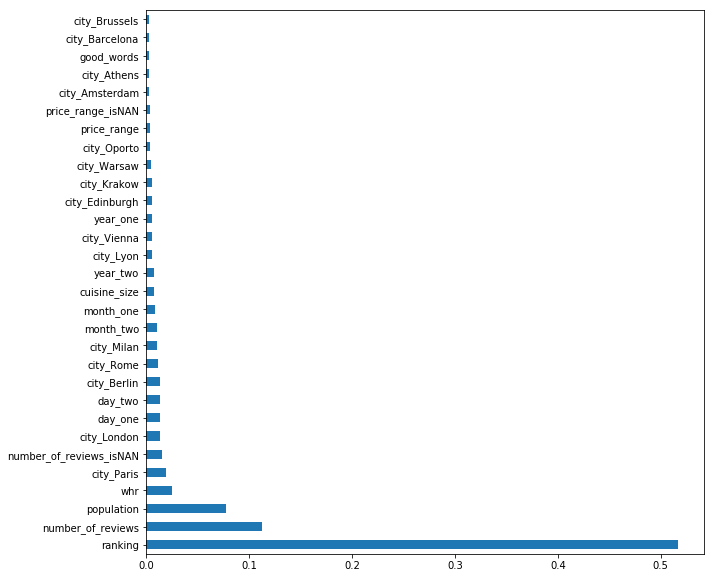

In [92]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')

In [93]:
train_data.columns[:100]

Index(['ranking', 'price_range', 'number_of_reviews', 'rating',
       'cuisine_style_isNAN', 'price_range_isNAN', 'number_of_reviews_isNAN',
       'cuisine_size', 'whr', 'year_one', 'month_one', 'day_one', 'year_two',
       'month_two', 'day_two', 'good_words', 'population', 'city_Amsterdam',
       'city_Athens', 'city_Barcelona', 'city_Berlin', 'city_Bratislava',
       'city_Brussels', 'city_Budapest', 'city_Copenhagen', 'city_Dublin',
       'city_Edinburgh', 'city_Geneva', 'city_Hamburg', 'city_Helsinki',
       'city_Krakow', 'city_Lisbon', 'city_Ljubljana', 'city_London',
       'city_Luxembourg', 'city_Lyon', 'city_Madrid', 'city_Milan',
       'city_Munich', 'city_Oporto', 'city_Oslo', 'city_Paris', 'city_Prague',
       'city_Rome', 'city_Stockholm', 'city_Vienna', 'city_Warsaw',
       'city_Zurich', 'city_nan', 'Bar', 'Pub', 'European', 'Scandinavian',
       'Gluten', 'Free', 'Options', 'Vegetarian', 'Friendly', 'Vegan',
       'Italian', 'Mediterranean', 'Seafood', 'Fr

# Submission
Если все устраевает - готовим Submission на кагл

In [94]:
test_data.sample(10)

,ranking,price_range,number_of_reviews,rating,cuisine_style_isNAN,price_range_isNAN,number_of_reviews_isNAN,cuisine_size,whr,year_one,...,Ukrainian,Albanian,Polynesian,Caucasian,Uzbek,Salvadoran,Xinjiang,Burmese,Fujian,Latvian
5868,5267.0,2,8.0,0.0,1,1,0,7,6.403,2017,...,0,0,0,0,0,0,0,0,0,0
9486,2028.0,2,7.0,0.0,0,0,0,2,6.891,2018,...,0,0,0,0,0,0,0,0,0,0
5222,1641.0,2,276.0,0.0,0,0,0,9,5.964,2017,...,0,0,0,0,0,0,0,0,0,0
4657,2903.0,2,12.0,0.0,1,1,0,8,6.951,2017,...,0,0,0,0,0,0,0,0,0,0
8237,11708.0,2,5.0,0.0,1,1,0,6,6.442,2017,...,0,0,0,0,0,0,0,0,0,0
9376,4473.0,2,12.0,0.0,1,1,0,7,6.403,2017,...,0,0,0,0,0,0,0,0,0,0
2159,1947.0,2,11.0,0.0,1,1,0,8,7.377,2017,...,0,0,0,0,0,0,0,0,0,0
8799,828.0,2,12.0,0.0,1,1,0,8,7.284,2017,...,0,0,0,0,0,0,0,0,0,0
7361,1275.0,2,545.0,0.0,0,0,0,7,6.714,2017,...,0,0,0,0,0,0,0,0,0,0
2123,466.0,2,91.0,0.0,0,0,0,7,5.195,2018,...,0,0,0,0,0,0,0,0,0,0


In [95]:
test_data = test_data.drop('rating', axis=1)

In [96]:
sample_submission

,restaurant_id,rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [97]:
predict_submission = pd.Series(model.predict(test_data)).apply(lambda x: round(x *2) / 2)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [98]:
len(predict_submission)

10000

In [99]:
sample_submission['rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.columns = ['Restaurant_id', 'Rating']
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,2.5
7,id_7,2.5
8,id_8,4.0
9,id_9,4.5
